In [24]:
import numpy as np
import pandas as pd
import zipfile
import re
from operator import itemgetter
import random
import matplotlib
import matplotlib.pyplot as plt
archive = zipfile.ZipFile('hwk3_datasets.zip', 'r')
archive.extractall()
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn import tree
from sklearn.svm import LinearSVC

In [5]:
#load data
def load_data(filename):
    f = open(filename, 'r')
    my_data= f.read()
    return my_data


In [11]:
yelp_train=load_data('yelp-train.txt')
yelp_test=load_data('yelp-test.txt')
yelp_valid=load_data('yelp-valid.txt')

In [6]:
#omit punctuation and conver to lower case
def  Datacleansing(dataset):
    result= re.sub(r'[^\w\s]','',dataset)
    result=result.lower()
    return result


In [12]:
yelp_train=Datacleansing(yelp_train)
yelp_valid=Datacleansing(yelp_valid)
yelp_test=Datacleansing(yelp_test)

In [13]:
def split(dataset):  
    comments =list()
    rating=list()
    splitted = dataset.rstrip("\n").split("\n")#reviews contains comment and rating
    for i in range(len(splitted)):
        review = splitted[i].split('\t')
        comments.append(review[0])
        rating.append(review[1])
        df1=pd.DataFrame(comments,columns=["comment"]).T
        df2=pd.DataFrame(rating,columns=["rating"]).T
    return pd.concat([df1,df2]).T


In [14]:
yelp_train=split(yelp_train)
yelp_valid=split(yelp_valid)
yelp_test=split(yelp_test)
yelp_train['rating']=yelp_train['rating'].apply(int)
yelp_valid['rating']=yelp_valid['rating'].apply(int)
yelp_test['rating']=yelp_test['rating'].apply(int)

In [15]:
#create vocabulary using train_set
def creatVocab(dataset):
    vocab={}
    for sentence in dataset:
        temp=sentence.split()
        for word in temp:
            if word in vocab:
                vocab[word]+=1;
            else:
                vocab[word]=1;
    vocab=sorted(vocab.items(), key=itemgetter(1),reverse=True)
    return vocab
vocab=creatVocab(yelp_train["comment"])
del vocab[10000::]

def save_vocab(name, vocab):
    file = open(name,"w")
    for i in range(10000):
        text = ""
        try:
            text += str(vocab[i][0])+ '\t'+ str(i+1) +'\t' +str(vocab[i][1])
           
        except ValueError:
            j=0
        text += '\n'
        file.write(text)


In [ ]:
save_vocab("yelp-vocab.txt",vocab)

In [6]:
def get_feature(vocabulary):
    f = []
    for i in range(10000):
        f.append(vocabulary[i][0])
    return f
#save dataset
def save_dataset(filename,rating,comment,feature):
    file = open(filename,"w")
    s=""
    for i in range(len(rating)):
        sentence = comment[i].split()
        for word in sentence:
            if word in feature:
                s+=str(feature.index(word))+" ";
        s+='\t' + str(rating[i]) + '\n' 
    file.write(s)
    file.close()

               

In [ ]:
#save dataset
save_dataset("yelp-test.txt",yelp_test['rating'],yelp_test['comment'],get_feature(vocab))
save_dataset("yelp-valid.txt",yelp_valid['rating'],yelp_valid['comment'],get_feature(vocab))
save_dataset("yelp-train.txt",yelp_train['rating'],yelp_train['comment'],get_feature(vocab))

In [16]:
#Binary Bag-of-word
def BBW(example,vocab):
    vector=np.zeros((10000,1))
    for i in range(10000):
        if vocab[i][0] in example:
            vector[i]=1
        else:
            vector[i]=0
    return vector

In [8]:
for i in range(len(yelp_train)):
    if(i==0):
        yelp_train_X=np.array(BBW(yelp_train["comment"][0],vocab)).T
    else:
        yelp_train_X=np.row_stack((yelp_train_X,BBW(yelp_train["comment"][i],vocab).T))
#np.savetxt("yelp_train_X.txt",yelp_train_X)


In [9]:
for i in range(len(yelp_valid)):
    if(i==0):
        yelp_valid_X=np.array(BBW(yelp_valid["comment"][0],vocab)).T
    else:
        yelp_valid_X=np.row_stack((yelp_valid_X,BBW(yelp_valid["comment"][i],vocab).T))
#np.savetxt("yelp_valid_X.txt",yelp_valid_X)

In [10]:
for i in range(len(yelp_test)):
    if(i==0):
        yelp_test_X=np.array(BBW(yelp_test["comment"][0],vocab)).T
    else:
        yelp_test_X=np.row_stack((yelp_test_X,BBW(yelp_test["comment"][i],vocab).T))
#np.savetxt("yelp_test_X.txt",yelp_test_X)

In [17]:
#Frequency Bag-of-word
def word_count(string):
    counts = dict()
    words = string.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts   
     
def FBW(example,vocab):
    vector=np.zeros((10000,1))
    collection=word_count(example)
    example=example.split()
    for i in range(10000):
        if vocab[i][0] in example:
            vector[i]=collection[vocab[i][0]]
        else:
            vector[i]=0
    if sum(vector)==0:
        return np.zeros((10000,1))
    return vector/sum(vector)

In [18]:
def RandomClassifier(dataset):
    prediction=list()
    for i in range(len(dataset)):
        x=random.randint(1,5)
        prediction.append(x)
    return prediction

def MajorityClassifier(trainset,testset):
    mode=int(trainset.mode().values[0])
    prediction=np.full((len(testset),),mode)
    return np.ndarray.tolist(prediction)
randomPrediction=RandomClassifier(yelp_test['comment'])
majorPrediction=MajorityClassifier(yelp_train['rating'],yelp_test)

In [19]:
#confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn import tree
from sklearn.svm import LinearSVC
a=confusion_matrix(yelp_test['rating'],randomPrediction)
b=confusion_matrix(yelp_test['rating'],majorPrediction)
print("confusion matrix for random classifier:\n", a)
print("confusion matrix for majority classifier:\n", b)
#F1 score
F1_random=f1_score(yelp_test['rating'],randomPrediction,average='macro')
F1_major=f1_score(yelp_test['rating'],majorPrediction,average='macro')
print("F1 score for random classifier is: ",F1_random)
print("F1 score for majority classifier is: ",F1_major)

confusion matrix for random classifier:
 [[ 32  33  21  28  29]
 [ 43  39  33  40  35]
 [ 53  50  57  69  71]
 [139 142 136 148 137]
 [136 125 153 151 100]]
confusion matrix for majority classifier:
 [[  0   0   0 143   0]
 [  0   0   0 190   0]
 [  0   0   0 300   0]
 [  0   0   0 702   0]
 [  0   0   0 665   0]]
F1 score for random classifier is:  0.1735515529985796
F1 score for majority classifier is:  0.10392301998519615


F:\anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [14]:
from sklearn.naive_bayes import BernoulliNB
from sklearn import tree
from sklearn.svm import LinearSVC
X_train=yelp_train_X
X_valid=yelp_valid_X
X_test=yelp_test_X
Y_train=np.array(yelp_train['rating'])
Y_valid=np.array(yelp_valid['rating'])
Y_test=np.array(yelp_test['rating'])

In [15]:


k = np.arange(0.01,2,0.02)
F1_valid_collection=list()
F1_train_collection=list()

for i in k:
    model=BernoulliNB(alpha=i)
    fit=model.fit(X_train,Y_train)
    prediction_train = fit.predict(X_train)
    prediction_valid = fit.predict(X_valid)
    F1_valid = f1_score(Y_valid, prediction_valid, average='macro')   
    F1_train = f1_score(Y_train,prediction_train, average='macro')
    F1_train_collection.append(F1_train)
    F1_valid_collection.append(F1_valid)

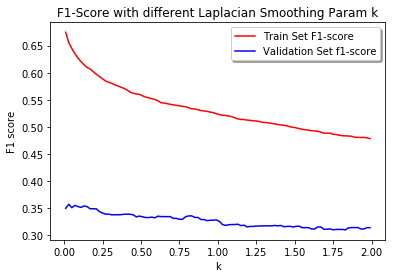

In [16]:
#plot
plt.plot(k, F1_train_collection, color='r', label="Train Set F1-score")
plt.plot(k, F1_valid_collection, color='b', label="Validation Set f1-score")
plt.legend(loc='best', shadow=True)
plt.xlabel('k')
plt.ylabel('F1 score')
plt.title('F1-Score with different Laplacian Smoothing Param k')
plt.show() 

In [17]:
print(k)
print(F1_valid_collection)

[0.01 0.03 0.05 0.07 0.09 0.11 0.13 0.15 0.17 0.19 0.21 0.23 0.25 0.27
 0.29 0.31 0.33 0.35 0.37 0.39 0.41 0.43 0.45 0.47 0.49 0.51 0.53 0.55
 0.57 0.59 0.61 0.63 0.65 0.67 0.69 0.71 0.73 0.75 0.77 0.79 0.81 0.83
 0.85 0.87 0.89 0.91 0.93 0.95 0.97 0.99 1.01 1.03 1.05 1.07 1.09 1.11
 1.13 1.15 1.17 1.19 1.21 1.23 1.25 1.27 1.29 1.31 1.33 1.35 1.37 1.39
 1.41 1.43 1.45 1.47 1.49 1.51 1.53 1.55 1.57 1.59 1.61 1.63 1.65 1.67
 1.69 1.71 1.73 1.75 1.77 1.79 1.81 1.83 1.85 1.87 1.89 1.91 1.93 1.95
 1.97 1.99]
[0.3490164484683026, 0.35662981593128007, 0.3502980157079288, 0.35456952725554963, 0.35228767871493194, 0.35078929812721676, 0.35351889391816715, 0.35211420697975654, 0.3481658646704147, 0.3482151172970176, 0.3481504003699704, 0.34293683281719967, 0.3403100288331621, 0.3383224482887961, 0.3383275478270594, 0.33709956580668254, 0.3372668585567843, 0.3372123174709923, 0.3373668750320813, 0.3381246309246309, 0.3381992471437412, 0.33820627874628517, 0.3369326219146634, 0.3332357014463544, 0

In [18]:
model=BernoulliNB(alpha=0.03)
fit=model.fit(X_train,Y_train)
prediction_train = fit.predict(X_train)
prediction_valid = fit.predict(X_valid)
prediction_test = fit.predict(X_test)
F1_valid = f1_score(Y_valid, prediction_valid, average='macro')   
F1_train = f1_score(Y_train,prediction_train, average='macro')
F1_test = f1_score(Y_test,prediction_test, average='macro')
print("F1 score for train set:",F1_train)
print("F1 score for valid set:",F1_valid)
print("F1 score for test set:",F1_test)

F1 score for train set: 0.6554711753880327
F1 score for valid set: 0.35662981593128007
F1 score for test set: 0.3721534723175413


In [19]:
from sklearn import tree
from sklearn.svm import LinearSVC
#hyperparameter penalty para
c_penalty= np.arange(0.01, 0.2, 0.05)
F1_valid_collection2=list()
F1_train_collection2=list()
for i in c_penalty:
    model2=LinearSVC(C=i)
    fit2= model2.fit(X_train, Y_train)
    prediction_train2 = fit2.predict(X_train)
    prediction_valid2 = fit2.predict(X_valid)
    F1_valid2 = f1_score(Y_valid, prediction_valid2, average='macro')   
    F1_train2 = f1_score(Y_train, prediction_train2, average='macro')
    F1_train_collection2.append(F1_train2)
    F1_valid_collection2.append(F1_valid2)

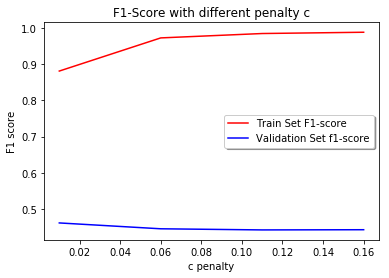

In [20]:
#plot
plt.plot(c_penalty, F1_train_collection2, color='r', label="Train Set F1-score")
plt.plot(c_penalty, F1_valid_collection2, color='b', label="Validation Set f1-score")
plt.legend(loc='best', shadow=True)
plt.xlabel('c penalty')
plt.ylabel('F1 score')
plt.title('F1-Score with different penalty c')
plt.show() 

In [21]:
print(c_penalty)
print( F1_valid_collection2)

[0.01 0.06 0.11 0.16]
[0.46114395202301955, 0.4449426936439086, 0.4418261759301544, 0.4423802030710897]


In [22]:
model=LinearSVC(C=0.02)
fit=model.fit(X_train,Y_train)
prediction_train = fit.predict(X_train)
prediction_valid = fit.predict(X_valid)
prediction_test = fit.predict(X_test)
F1_valid = f1_score(Y_valid, prediction_valid, average='macro')   
F1_train = f1_score(Y_train,prediction_train, average='macro')
F1_test = f1_score(Y_test,prediction_test, average='macro')
print("F1 score for train set:",F1_train)
print("F1 score for valid set:",F1_valid)
print("F1 score for test set:",F1_test)

F1 score for train set: 0.9322880355692773
F1 score for valid set: 0.46348321312717966
F1 score for test set: 0.43239419473847096


In [23]:
from sklearn import tree
#hyperparameter max depth
depth = np.arange(5,100,5)
F1_valid_collection3=list()
F1_train_collection3=list()
for i in depth:
    model3=tree.DecisionTreeClassifier(criterion='gini',max_depth=i)
    fit3=model3.fit(X_train,Y_train)
    prediction_train3 = fit3.predict(X_train)
    prediction_valid3 = fit3.predict(X_valid)
    F1_valid3 = f1_score(Y_valid, prediction_valid3, average='macro')   
    F1_train3 = f1_score(Y_train, prediction_train3, average='macro')
    F1_train_collection3.append(F1_train3)
    F1_valid_collection3.append(F1_valid3)


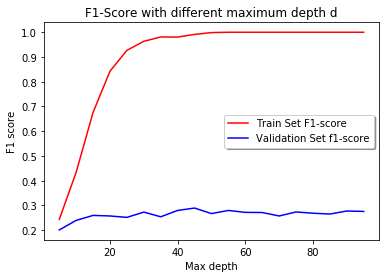

In [24]:
#plot
plt.plot(depth, F1_train_collection3, color='r', label="Train Set F1-score")
plt.plot(depth, F1_valid_collection3, color='b', label="Validation Set f1-score")
plt.legend(loc='best', shadow=True)
plt.xlabel('Max depth')
plt.ylabel('F1 score')
plt.title('F1-Score with different maximum depth d')
plt.show() 

In [25]:
print(depth)
print(F1_valid_collection3)

[ 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95]
[0.20094033625948518, 0.23949790345527072, 0.2596068168714573, 0.25729522949987005, 0.25164642349288313, 0.2729434573771026, 0.25403316941825344, 0.2797143829258932, 0.2892714316124135, 0.26698168818936097, 0.2796186914181121, 0.27187116269702694, 0.2712973018384617, 0.25728212988873583, 0.2735231811520075, 0.2684661528661748, 0.2650907016881745, 0.27735457800146734, 0.2756597564371811]


In [26]:
model3=tree.DecisionTreeClassifier(criterion='gini',max_depth=95)
fit3=model3.fit(X_train,Y_train)
prediction_train = fit3.predict(X_train)
prediction_valid = fit3.predict(X_valid)
prediction_test = fit3.predict(X_test)
F1_valid = f1_score(Y_valid, prediction_valid, average='macro')   
F1_train = f1_score(Y_train,prediction_train, average='macro')
F1_test = f1_score(Y_test,prediction_test, average='macro')
print("F1 score for train set:",F1_train)
print("F1 score for valid set:",F1_valid)
print("F1 score for test set:",F1_test)


F1 score for train set: 1.0
F1 score for valid set: 0.26466885058178
F1 score for test set: 0.28694136224606687


In [27]:
#hyperparameter: min sample leaf
min_samples_leaves = np.arange(2, 100, 5)
F1_valid_collection3=list()
F1_train_collection3=list()
for min_samples_leaf in min_samples_leaves:
    model3=tree.DecisionTreeClassifier(criterion='gini',max_depth=95,min_samples_leaf=min_samples_leaf)
    fit3=model3.fit(X_train,Y_train)
    prediction_train3 = fit3.predict(X_train)
    prediction_valid3 = fit3.predict(X_valid)
    F1_valid3 = f1_score(Y_valid, prediction_valid3, average='macro')   
    F1_train3 = f1_score(Y_train, prediction_train3, average='macro')
    F1_train_collection3.append(F1_train3)
    F1_valid_collection3.append(F1_valid3)


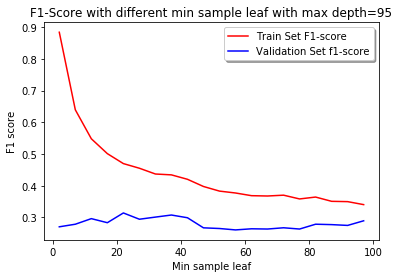

In [28]:
#plot 
plt.plot(min_samples_leaves, F1_train_collection3, color='r', label="Train Set F1-score")
plt.plot(min_samples_leaves, F1_valid_collection3, color='b', label="Validation Set f1-score")
plt.legend(loc='best', shadow=True)
plt.xlabel('Min sample leaf')
plt.ylabel('F1 score')
plt.title('F1-Score with different min sample leaf with max depth=95')
plt.show() 

In [29]:
print(min_samples_leaves)
print(F1_valid_collection3)

[ 2  7 12 17 22 27 32 37 42 47 52 57 62 67 72 77 82 87 92 97]
[0.27040556389507575, 0.27854458565384843, 0.2961494856481931, 0.2833626023412531, 0.31406899392041643, 0.29429661853925176, 0.3010193569791742, 0.30755357866602473, 0.298972031174547, 0.2671894793939599, 0.2650510595274297, 0.260610165093725, 0.2641553664773479, 0.26340547954790416, 0.26735551100225896, 0.2633850902572951, 0.2785929068240834, 0.2772966453369798, 0.2747937707635211, 0.28936990414832187]


In [30]:
model3=tree.DecisionTreeClassifier(criterion='gini',max_depth=95,min_samples_leaf=22)
fit3=model3.fit(X_train,Y_train)
prediction_train = fit3.predict(X_train)
prediction_valid = fit3.predict(X_valid)
prediction_test = fit3.predict(X_test)
F1_valid = f1_score(Y_valid, prediction_valid, average='macro')   
F1_train = f1_score(Y_train,prediction_train, average='macro')
F1_test = f1_score(Y_test,prediction_test, average='macro')
print("F1 score for train set:",F1_train)
print("F1 score for valid set:",F1_valid)
print("F1 score for test set:",F1_test)


F1 score for train set: 0.4696488723032758
F1 score for valid set: 0.31406899392041643
F1 score for test set: 0.3277245957780928


In [31]:
#hyperparameter: max leaf nodes
max_leaf_nodes_collect=np.arange(2,300,20)
F1_valid_collection3=list()
F1_train_collection3=list()
for max_leaf_nodes in max_leaf_nodes_collect:
    model3=tree.DecisionTreeClassifier(criterion='gini',max_depth=95,min_samples_leaf=22,max_leaf_nodes=max_leaf_nodes)
    fit3=model3.fit(X_train,Y_train)
    prediction_train3 = fit3.predict(X_train)
    prediction_valid3 = fit3.predict(X_valid)
    F1_valid3 = f1_score(Y_valid, prediction_valid3, average='macro')   
    F1_train3 = f1_score(Y_train, prediction_train3, average='macro')
    F1_train_collection3.append(F1_train3)
    F1_valid_collection3.append(F1_valid3)

F:\anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


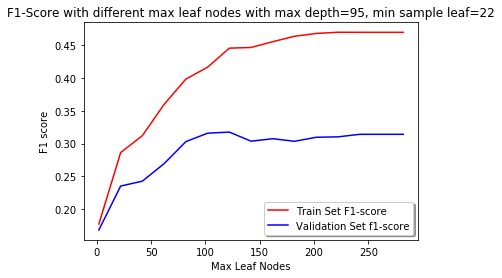

In [32]:
#plot 
plt.plot(max_leaf_nodes_collect, F1_train_collection3, color='r', label="Train Set F1-score")
plt.plot(max_leaf_nodes_collect, F1_valid_collection3, color='b', label="Validation Set f1-score")
plt.legend(loc='best', shadow=True)
plt.xlabel('Max Leaf Nodes')
plt.ylabel('F1 score')
plt.title('F1-Score with different max leaf nodes with max depth=95, min sample leaf=22')
plt.show() 

In [33]:
print(max_leaf_nodes_collect)
print(F1_valid_collection3)

[  2  22  42  62  82 102 122 142 162 182 202 222 242 262 282]
[0.16825256582799963, 0.23514433473799926, 0.24263651390236643, 0.2693584223860499, 0.30292645349390485, 0.31579265070248164, 0.31745684354884807, 0.3035865621467764, 0.30738177184682064, 0.3034072296627001, 0.3095806197525851, 0.31020932332414675, 0.31406899392041643, 0.31406899392041643, 0.31406899392041643]


In [35]:
model3=tree.DecisionTreeClassifier(criterion='gini',max_depth=95,min_samples_leaf=22,max_leaf_nodes=122)
fit3=model3.fit(X_train,Y_train)
prediction_train = fit3.predict(X_train)
prediction_valid = fit3.predict(X_valid)
prediction_test = fit3.predict(X_test)
F1_valid = f1_score(Y_valid, prediction_valid, average='macro')   
F1_train = f1_score(Y_train,prediction_train, average='macro')
F1_test = f1_score(Y_test,prediction_test, average='macro')
print("F1 score for train set:",F1_train)
print("F1 score for valid set:",F1_valid)
print("F1 score for test set:",F1_test)


F1 score for train set: 0.44548570975002233
F1 score for valid set: 0.31745684354884807
F1 score for test set: 0.3352318312362972


In [36]:
print("#Q3: using frequency bag of words")



#Q3: using frequency bag of words


In [38]:
for i in range(len(yelp_train)):
    if(i==0):
        yelp_train_X_2=np.array(FBW(yelp_train["comment"][0],vocab)).T
    else:
        yelp_train_X_2=np.row_stack((yelp_train_X_2,FBW(yelp_train["comment"][i],vocab).T))
#np.savetxt("yelp_train_X_2.txt",yelp_train_X_2)

In [39]:
for i in range(len(yelp_valid)):
    if(i==0):
        yelp_valid_X_2=np.array(FBW(yelp_valid["comment"][0],vocab)).T
    else:
        yelp_valid_X_2=np.row_stack((yelp_valid_X_2,FBW(yelp_valid["comment"][i],vocab).T))
#np.savetxt("yelp_valid_X_2.txt",yelp_valid_X_2)


In [45]:
for i in range(len(yelp_test)):
    if(i==0):
        yelp_test_X_2=np.array(FBW(yelp_test["comment"][0],vocab)).T
    else:
        yelp_test_X_2=np.row_stack((yelp_test_X_2,FBW(yelp_test["comment"][i],vocab).T))         

In [46]:
X_train_2=yelp_train_X_2
X_valid_2=yelp_valid_X_2
X_test_2=yelp_test_X_2


In [47]:
from sklearn.naive_bayes import GaussianNB
#Gaussian Naive Bayes
model=GaussianNB()
fit=model.fit(X_train_2,Y_train)
prediction_train = fit.predict(X_train_2)
prediction_valid = fit.predict(X_valid_2)
prediction_test = fit.predict(X_test_2)
F1_train = f1_score(Y_train, prediction_train, average='macro')
F1_valid = f1_score(Y_valid, prediction_valid, average='macro')   
F1_test = f1_score(Y_test, prediction_test, average='macro')   
print("F1 score for train set:",F1_train)
print("F1 score for valid set:",F1_valid)
print("F1 score for test set:",F1_test)

F1 score for train set: 0.7879844613865794
F1 score for valid set: 0.24561901520780366
F1 score for test set: 0.2477846680185553


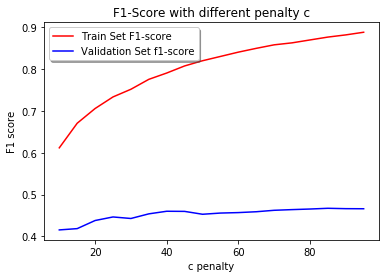

In [48]:
#Linear SVM
#hyperparameter penalty para
c_penalty= np.arange(10, 100, 5)
F1_valid_collection2=list()
F1_train_collection2=list()
for i in c_penalty:
    model2=LinearSVC(C=i)
    fit2= model2.fit(X_train_2, Y_train)
    prediction_train2 = fit2.predict(X_train_2)
    prediction_valid2 = fit2.predict(X_valid_2)
    F1_valid2 = f1_score(Y_valid, prediction_valid2, average='macro')   
    F1_train2 = f1_score(Y_train, prediction_train2, average='macro')
    #F1_test2 = f1_score(Y_train, prediction_test2, average='macro')
    F1_train_collection2.append(F1_train2)
    F1_valid_collection2.append(F1_valid2)
    #F1_test_collection2.append(F1_test2)
#plot
plt.plot(c_penalty, F1_train_collection2, color='r', label="Train Set F1-score")
plt.plot(c_penalty, F1_valid_collection2, color='b', label="Validation Set f1-score")
plt.legend(loc='best', shadow=True)
plt.xlabel('c penalty')
plt.ylabel('F1 score')
plt.title('F1-Score with different penalty c')
plt.show()

In [49]:
print(c_penalty)
print( F1_valid_collection2)

[10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95]
[0.41562269273763697, 0.4187208427153653, 0.43806749083734964, 0.44655165463673596, 0.44290718151435815, 0.45396950657367324, 0.46017582220292075, 0.45985206274476653, 0.45300167177011685, 0.4558519311071718, 0.45697721427909455, 0.4590099801628698, 0.4624611807936224, 0.4640908380029115, 0.4654881603749114, 0.4672464246484772, 0.4663581145100652, 0.46613654347666256]


In [50]:
model2=LinearSVC(C=90)
fit2= model2.fit(X_train_2, Y_train)
prediction_train2 = fit2.predict(X_train_2)
prediction_valid2 = fit2.predict(X_valid_2)
prediction_test2 = fit2.predict(X_test_2)
F1_valid2 = f1_score(Y_valid, prediction_valid2, average='macro')   
F1_train2 = f1_score(Y_train, prediction_train2, average='macro')
F1_test2 = f1_score(Y_test, prediction_test2, average='macro')
print("F1 score for train set:",F1_train2)
print("F1 score for valid set:",F1_valid2)
print("F1 score for test set:",F1_test2)

F1 score for train set: 0.8812341310515575
F1 score for valid set: 0.4663581145100652
F1 score for test set: 0.46179911364564674


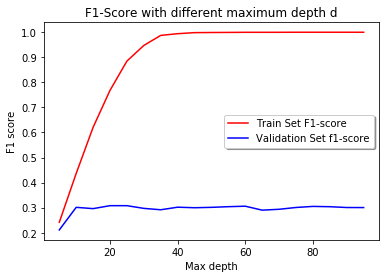

In [51]:
#Decision Tree
#hyperparameter max depth
depth = np.arange(5,100,5)
F1_valid_collection3=list()
F1_train_collection3=list()
for i in depth:
    model3=tree.DecisionTreeClassifier(criterion='gini',max_depth=i)
    fit3=model3.fit(X_train_2,Y_train)
    prediction_train3 = fit3.predict(X_train_2)
    prediction_valid3 = fit3.predict(X_valid_2)
    F1_valid3 = f1_score(Y_valid, prediction_valid3, average='macro')   
    F1_train3 = f1_score(Y_train, prediction_train3, average='macro')
    F1_train_collection3.append(F1_train3)
    F1_valid_collection3.append(F1_valid3)
#plot
plt.plot(depth, F1_train_collection3, color='r', label="Train Set F1-score")
plt.plot(depth, F1_valid_collection3, color='b', label="Validation Set f1-score")
plt.legend(loc='best', shadow=True)
plt.xlabel('Max depth')
plt.ylabel('F1 score')
plt.title('F1-Score with different maximum depth d')
plt.show() 

In [52]:
print(depth)
print(F1_valid_collection3)

[ 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95]
[0.21099067523420087, 0.30110574638045917, 0.2959773629167117, 0.3077436485770997, 0.3077668406459583, 0.2969560297935576, 0.29144820402018656, 0.30167637361461663, 0.29953324448715557, 0.30107681845579937, 0.3037434495589383, 0.3056378258914856, 0.2898984945839665, 0.2933708791654217, 0.3005542055841796, 0.3048292761044376, 0.30364436338634365, 0.3003950642859445, 0.3001747374380357]


In [53]:
model3=tree.DecisionTreeClassifier(criterion='gini',max_depth=45)
fit3=model3.fit(X_train_2,Y_train)
prediction_train = fit3.predict(X_train_2)
prediction_valid = fit3.predict(X_valid_2)
prediction_test = fit3.predict(X_test_2)
F1_valid = f1_score(Y_valid, prediction_valid, average='macro')   
F1_train = f1_score(Y_train,prediction_train, average='macro')
F1_test = f1_score(Y_test,prediction_test, average='macro')
print("F1 score for train set:",F1_train)
print("F1 score for valid set:",F1_valid)
print("F1 score for test set:",F1_test)

F1 score for train set: 0.997137502264812
F1 score for valid set: 0.31689271332673313
F1 score for test set: 0.28962855331516874


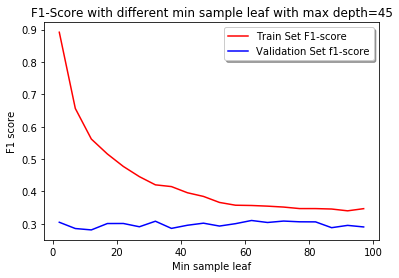

In [54]:
#hyperparameter: min sample leaf
min_samples_leaves = np.arange(2, 100, 5)
F1_valid_collection3=list()
F1_train_collection3=list()
for min_samples_leaf in min_samples_leaves:
    model3=tree.DecisionTreeClassifier(criterion='gini',max_depth=45,min_samples_leaf=min_samples_leaf)
    fit3=model3.fit(X_train_2,Y_train)
    prediction_train3 = fit3.predict(X_train_2)
    prediction_valid3 = fit3.predict(X_valid_2)
    F1_valid3 = f1_score(Y_valid, prediction_valid3, average='macro')   
    F1_train3 = f1_score(Y_train, prediction_train3, average='macro')
    F1_train_collection3.append(F1_train3)
    F1_valid_collection3.append(F1_valid3)

#plot 
plt.plot(min_samples_leaves, F1_train_collection3, color='r', label="Train Set F1-score")
plt.plot(min_samples_leaves, F1_valid_collection3, color='b', label="Validation Set f1-score")
plt.legend(loc='best', shadow=True)
plt.xlabel('Min sample leaf')
plt.ylabel('F1 score')
plt.title('F1-Score with different min sample leaf with max depth=45')
plt.show() 

In [55]:
print(min_samples_leaves)
print(F1_valid_collection3)

[ 2  7 12 17 22 27 32 37 42 47 52 57 62 67 72 77 82 87 92 97]
[0.3048784786333235, 0.285530163616288, 0.2812364098843362, 0.30095172630853634, 0.3011045248396671, 0.2909866887564311, 0.3080898432518312, 0.28596786313994443, 0.29564472053877333, 0.3020564476502276, 0.29315702592009096, 0.30052950199458367, 0.31036705262312714, 0.3041882665460673, 0.3085843021705025, 0.30629604588742704, 0.3060440545747247, 0.2881254771186147, 0.2952535259655825, 0.2903996363713224]


In [56]:
model3=tree.DecisionTreeClassifier(criterion='gini',max_depth=45, min_samples_leaf=62)
fit3=model3.fit(X_train_2,Y_train)
prediction_train = fit3.predict(X_train_2)
prediction_valid = fit3.predict(X_valid_2)
prediction_test = fit3.predict(X_test_2)
F1_valid = f1_score(Y_valid, prediction_valid, average='macro')   
F1_train = f1_score(Y_train,prediction_train, average='macro')
F1_test = f1_score(Y_test,prediction_test, average='macro')
print("F1 score for train set:",F1_train)
print("F1 score for valid set:",F1_valid)
print("F1 score for test set:",F1_test)

F1 score for train set: 0.3566998619855164
F1 score for valid set: 0.31036705262312714
F1 score for test set: 0.2692568764668576


F:\anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


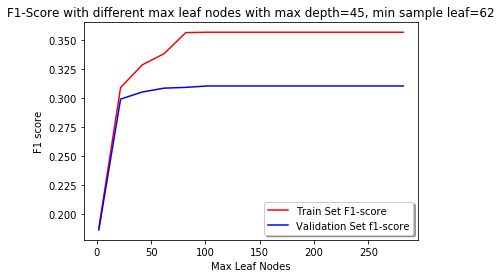

In [57]:
#hyperparameter: max leaf nodes
max_leaf_nodes_collect=np.arange(2,300,20)
F1_valid_collection3=list()
F1_train_collection3=list()
for max_leaf_nodes in max_leaf_nodes_collect:
    model3=tree.DecisionTreeClassifier(criterion='gini',max_depth=45,min_samples_leaf=62,max_leaf_nodes=max_leaf_nodes)
    fit3=model3.fit(X_train_2,Y_train)
    prediction_train3 = fit3.predict(X_train_2)
    prediction_valid3 = fit3.predict(X_valid_2)
    F1_valid3 = f1_score(Y_valid, prediction_valid3, average='macro')   
    F1_train3 = f1_score(Y_train, prediction_train3, average='macro')
    F1_train_collection3.append(F1_train3)
    F1_valid_collection3.append(F1_valid3)
#plot 
plt.plot(max_leaf_nodes_collect, F1_train_collection3, color='r', label="Train Set F1-score")
plt.plot(max_leaf_nodes_collect, F1_valid_collection3, color='b', label="Validation Set f1-score")
plt.legend(loc='best', shadow=True)
plt.xlabel('Max Leaf Nodes')
plt.ylabel('F1 score')
plt.title('F1-Score with different max leaf nodes with max depth=45, min sample leaf=62')
plt.show() 

In [58]:
print(max_leaf_nodes_collect)
print(F1_valid_collection3)

[  2  22  42  62  82 102 122 142 162 182 202 222 242 262 282]
[0.18618433440030127, 0.29903547230888583, 0.3051489125474637, 0.30846278103203, 0.30915180747510773, 0.31036705262312714, 0.31036705262312714, 0.31036705262312714, 0.31036705262312714, 0.31036705262312714, 0.31036705262312714, 0.31036705262312714, 0.31036705262312714, 0.31036705262312714, 0.31036705262312714]


In [59]:
model3=tree.DecisionTreeClassifier(criterion='gini',max_depth=45,min_samples_leaf=62,max_leaf_nodes=102)
fit3=model3.fit(X_train_2,Y_train)
prediction_train = fit3.predict(X_train_2)
prediction_valid = fit3.predict(X_valid_2)
prediction_test = fit3.predict(X_test_2)
F1_valid = f1_score(Y_valid, prediction_valid, average='macro')   
F1_train = f1_score(Y_train,prediction_train, average='macro')
F1_test = f1_score(Y_test,prediction_test, average='macro')
print("F1 score for train set:",F1_train)
print("F1 score for valid set:",F1_valid)
print("F1 score for test set:",F1_test)

F1 score for train set: 0.3566998619855164
F1 score for valid set: 0.31036705262312714
F1 score for test set: 0.2692568764668576


In [26]:
#Q4
def load_datab(filename):
    f = open(filename, 'rb')
    my_data= f.read()
    return my_data
#LOAD DATA
IMDB_train=load_datab('IMDB-train.txt')
IMDB_test=load_datab('IMDB-test.txt')
IMDB_valid=load_datab('IMDB-valid.txt')
#DECODING
IMDB_train=IMDB_train.decode("utf-8")
IMDB_valid=IMDB_valid.decode("utf-8")
IMDB_test=IMDB_test.decode("utf-8")
#DATA CLEANSE
IMDB_train=Datacleansing(IMDB_train)
IMDB_valid=Datacleansing(IMDB_valid)
IMDB_test=Datacleansing(IMDB_test)

IMDB_train=split(IMDB_train)
IMDB_valid=split(IMDB_valid)
IMDB_test=split(IMDB_test)
IMDB_train['rating']=IMDB_train['rating'].apply(int)
IMDB_valid['rating']=IMDB_valid['rating'].apply(int)
IMDB_test['rating']=IMDB_test['rating'].apply(int)

In [22]:
#create vocabulary
vocab2=creatVocab(IMDB_train["comment"])
del vocab2[10000::]
save_vocab("IMDB-vocab.txt",vocab2)


In [ ]:
#save dataset
save_dataset("IMDB-test.txt",IMDB_test['rating'],IMDB_test['comment'],get_feature(vocab2))
save_dataset("IMDB-valid.txt",IMDB_valid['rating'],IMDB_valid['comment'],get_feature(vocab2))
save_dataset("IMDB-train.txt",IMDB_train['rating'],IMDB_train['comment'],get_feature(vocab2))


In [62]:
for i in range(len(IMDB_train)):
    if(i==0):
        IMDB_train_X=np.array(BBW(IMDB_train["comment"][0],vocab2)).T
    else:
        IMDB_train_X=np.row_stack((IMDB_train_X,BBW(IMDB_train["comment"][i],vocab2).T))

In [63]:
for i in range(len(IMDB_valid)):
    if(i==0):
        IMDB_valid_X=np.array(BBW(IMDB_valid["comment"][0],vocab)).T
    else:
        IMDB_valid_X=np.row_stack((IMDB_valid_X,BBW(IMDB_valid["comment"][i],vocab2).T))

In [75]:
for i in range(len(IMDB_test)):
    if(i==0):
        IMDB_test_X=np.array(BBW(IMDB_test["comment"][0],vocab)).T
    else:
        IMDB_test_X=np.row_stack((IMDB_test_X,BBW(IMDB_test["comment"][i],vocab2).T))

KeyboardInterrupt: 

In [69]:
#Random classifier and Majority classifier
def RandomClassifier(dataset):
    prediction=list()
    for i in range(len(dataset)):
        x=random.randint(0,1)
        prediction.append(x)
    return prediction

def MajorityClassifier(trainset,testset):
    mode=int(trainset.mode().values[0])
    prediction=np.full((len(testset),),mode)
    return np.ndarray.tolist(prediction)
randomPrediction=RandomClassifier(IMDB_test['comment'])
majorPrediction=MajorityClassifier(IMDB_train['rating'],IMDB_test)

a=confusion_matrix(IMDB_test['rating'],randomPrediction)
b=confusion_matrix(IMDB_test['rating'],majorPrediction)
print("confusion matrix for random classifier:\n", a)
print("confusion matrix for majority classifier:\n", b)
F1_random=f1_score(IMDB_test['rating'],randomPrediction,average='macro')
F1_major=f1_score(IMDB_test['rating'],majorPrediction,average='macro')
print("F1 score for random classifier is: ",F1_random)
print("F1 score for majority classifier is: ",F1_major)


confusion matrix for random classifier:
 [[6181 6319]
 [6342 6158]]
confusion matrix for majority classifier:
 [[12500     0]
 [12500     0]]
F1 score for random classifier is:  0.49355957134882117
F1 score for majority classifier is:  0.3333333333333333


F:\anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
X_train=IMDB_train_X
X_valid=IMDB_valid_X
X_test=IMDB_test_X
Y_train=np.array(IMDB_train['rating'])
Y_valid=np.array(IMDB_valid['rating'])
Y_test=np.array(IMDB_test['rating'])

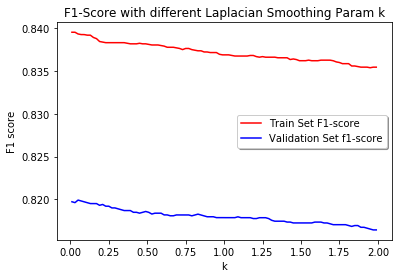

[0.01 0.03 0.05 0.07 0.09 0.11 0.13 0.15 0.17 0.19 0.21 0.23 0.25 0.27
 0.29 0.31 0.33 0.35 0.37 0.39 0.41 0.43 0.45 0.47 0.49 0.51 0.53 0.55
 0.57 0.59 0.61 0.63 0.65 0.67 0.69 0.71 0.73 0.75 0.77 0.79 0.81 0.83
 0.85 0.87 0.89 0.91 0.93 0.95 0.97 0.99 1.01 1.03 1.05 1.07 1.09 1.11
 1.13 1.15 1.17 1.19 1.21 1.23 1.25 1.27 1.29 1.31 1.33 1.35 1.37 1.39
 1.41 1.43 1.45 1.47 1.49 1.51 1.53 1.55 1.57 1.59 1.61 1.63 1.65 1.67
 1.69 1.71 1.73 1.75 1.77 1.79 1.81 1.83 1.85 1.87 1.89 1.91 1.93 1.95
 1.97 1.99]
[0.8197286122420135, 0.8196270578602247, 0.8199232869196121, 0.8198217164428289, 0.8197201407577066, 0.8196185598580186, 0.8195169737375363, 0.819514103119906, 0.819514103119906, 0.8193137858092734, 0.8194125028987398, 0.8192092867251469, 0.8192092867251469, 0.8190089646051748, 0.8190089646051748, 0.8189044230431142, 0.8188027912783944, 0.8187011542345941, 0.8187011542345941, 0.8187011542345941, 0.8184978642848031, 0.8184978642848031, 0.8183962113663358, 0.8184948899099387, 0.8185935664

In [67]:
k = np.arange(0.01,2,0.02)
F1_valid_collection=list()
F1_train_collection=list()


for i in k:
    model=BernoulliNB(alpha=i)
    fit=model.fit(X_train,Y_train)
    prediction_train = fit.predict(X_train)
    prediction_valid = fit.predict(X_valid)
    F1_valid = f1_score(Y_valid, prediction_valid, average='macro')   
    F1_train = f1_score(Y_train,prediction_train, average='macro')
    F1_train_collection.append(F1_train)
    F1_valid_collection.append(F1_valid)

#plot
plt.plot(k, F1_train_collection, color='r', label="Train Set F1-score")
plt.plot(k, F1_valid_collection, color='b', label="Validation Set f1-score")
plt.legend(loc='best', shadow=True)
plt.xlabel('k')
plt.ylabel('F1 score')
plt.title('F1-Score with different Laplacian Smoothing Param k')
plt.show() 

print(k)
print(F1_valid_collection)

2000


In [76]:
model=BernoulliNB(alpha=0.05)
fit=model.fit(X_train,Y_train)
prediction_train = fit.predict(X_train)
prediction_valid = fit.predict(X_valid)
prediction_test = fit.predict(X_test)
F1_valid = f1_score(Y_valid, prediction_valid, average='macro')   
F1_train = f1_score(Y_train,prediction_train, average='macro')
F1_test = f1_score(Y_test,prediction_test, average='macro')
print("F1 score for train set:",F1_train)
print("F1 score for valid set:",F1_valid)
print("F1 score for test set:",F1_test)

ValueError: Found input variables with inconsistent numbers of samples: [25000, 2000]

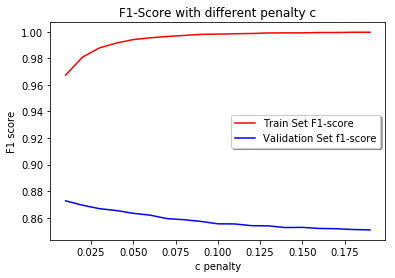

[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19]
[0.8726982572391415, 0.869397471535049, 0.8667998667998668, 0.8653999784639965, 0.8632999876969989, 0.8618999323309668, 0.8592998860329076, 0.8584997608645959, 0.8571995373265009, 0.8553990224973921, 0.8552990956193476, 0.8539997897596971, 0.8537994151976609, 0.852599286580547, 0.8526992207788779, 0.8518983871734362, 0.8516985748233041, 0.8510981759526555, 0.8507982752280616]


In [79]:
#hyperparameter penalty para
c_penalty= np.arange(0.01, 0.2, 0.01)
F1_valid_collection2=list()
F1_train_collection2=list()
for i in c_penalty:
    model2=LinearSVC(C=i)
    fit2= model2.fit(X_train, Y_train)
    prediction_train2 = fit2.predict(X_train)
    prediction_valid2 = fit2.predict(X_valid)
    F1_valid2 = f1_score(Y_valid, prediction_valid2, average='macro')   
    F1_train2 = f1_score(Y_train, prediction_train2, average='macro')
    F1_train_collection2.append(F1_train2)
    F1_valid_collection2.append(F1_valid2)

#plot
plt.plot(c_penalty, F1_train_collection2, color='r', label="Train Set F1-score")
plt.plot(c_penalty, F1_valid_collection2, color='b', label="Validation Set f1-score")
plt.legend(loc='best', shadow=True)
plt.xlabel('c penalty')
plt.ylabel('F1 score')
plt.title('F1-Score with different penalty c')
plt.show() 

print(c_penalty)
print( F1_valid_collection2)



In [ ]:
model=LinearSVC(C=0.01)
fit=model.fit(X_train,Y_train)
prediction_train = fit.predict(X_train)
prediction_valid = fit.predict(X_valid)
prediction_test = fit.predict(X_test)
F1_valid = f1_score(Y_valid, prediction_valid, average='macro')   
F1_train = f1_score(Y_train,prediction_train, average='macro')
F1_test = f1_score(Y_test,prediction_test, average='macro')
print("F1 score for train set:",F1_train)
print("F1 score for valid set:",F1_valid)
print("F1 score for test set:",F1_test)

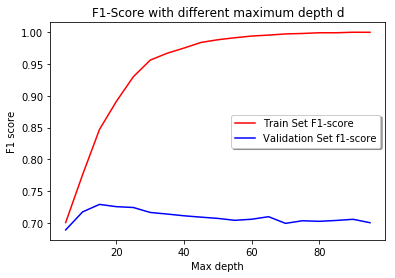

[ 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95]
[0.6888670480935297, 0.7172176710321736, 0.7290343449371015, 0.7254548367635267, 0.7241528051783712, 0.7163447102392153, 0.7138324088118966, 0.7111105135926905, 0.7089608377703305, 0.7069894516202584, 0.7039900422250205, 0.7056687744002761, 0.7096853652392616, 0.6991807475678444, 0.7032910245534927, 0.7023809523809523, 0.7037800821727253, 0.7055717231082874, 0.7001947114347098]


In [80]:
#hyperparameter max depth
depth = np.arange(5,100,5)
F1_valid_collection3=list()
F1_train_collection3=list()
for i in depth:
    model3=tree.DecisionTreeClassifier(criterion='gini',max_depth=i)
    fit3=model3.fit(X_train,Y_train)
    prediction_train3 = fit3.predict(X_train)
    prediction_valid3 = fit3.predict(X_valid)
    F1_valid3 = f1_score(Y_valid, prediction_valid3, average='macro')   
    F1_train3 = f1_score(Y_train, prediction_train3, average='macro')
    F1_train_collection3.append(F1_train3)
    F1_valid_collection3.append(F1_valid3)
#plot
plt.plot(depth, F1_train_collection3, color='r', label="Train Set F1-score")
plt.plot(depth, F1_valid_collection3, color='b', label="Validation Set f1-score")
plt.legend(loc='best', shadow=True)
plt.xlabel('Max depth')
plt.ylabel('F1 score')
plt.title('F1-Score with different maximum depth d')
plt.show() 
print(depth)
print(F1_valid_collection3)

In [ ]:
model3=tree.DecisionTreeClassifier(criterion='gini',max_depth=20)
fit3=model3.fit(X_train,Y_train)
prediction_train = fit3.predict(X_train)
prediction_valid = fit3.predict(X_valid)
prediction_test = fit3.predict(X_test)
F1_valid = f1_score(Y_valid, prediction_valid, average='macro')   
F1_train = f1_score(Y_train,prediction_train, average='macro')
F1_test = f1_score(Y_test,prediction_test, average='macro')
print("F1 score for train set:",F1_train)
print("F1 score for valid set:",F1_valid)
print("F1 score for test set:",F1_test)

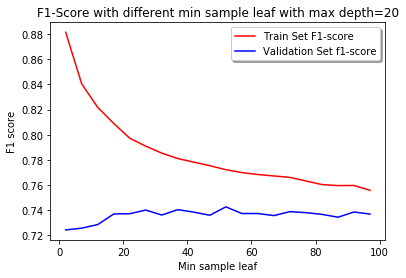

[ 2  7 12 17 22 27 32 37 42 47 52 57 62 67 72 77 82 87 92 97]
[0.7243168143948462, 0.7256971677274764, 0.7285632092608498, 0.7369958573141833, 0.7371888823102057, 0.7401036913103795, 0.7361389714564877, 0.7404258247774212, 0.7384496375965388, 0.7359690592597614, 0.7426525010074769, 0.7373380814587993, 0.737346639273087, 0.7357109315738143, 0.7388617522893487, 0.7380399090529945, 0.7366637079586026, 0.7344148955234004, 0.7385619576898106, 0.7369225776169561]


In [81]:
#hyperparameter: min sample leaf
min_samples_leaves = np.arange(2, 100, 5)
F1_valid_collection3=list()
F1_train_collection3=list()
for min_samples_leaf in min_samples_leaves:
    model3=tree.DecisionTreeClassifier(criterion='gini',max_depth=20,min_samples_leaf=min_samples_leaf)
    fit3=model3.fit(X_train,Y_train)
    prediction_train3 = fit3.predict(X_train)
    prediction_valid3 = fit3.predict(X_valid)
    F1_valid3 = f1_score(Y_valid, prediction_valid3, average='macro')   
    F1_train3 = f1_score(Y_train, prediction_train3, average='macro')
    F1_train_collection3.append(F1_train3)
    F1_valid_collection3.append(F1_valid3)
    
#plot 
plt.plot(min_samples_leaves, F1_train_collection3, color='r', label="Train Set F1-score")
plt.plot(min_samples_leaves, F1_valid_collection3, color='b', label="Validation Set f1-score")
plt.legend(loc='best', shadow=True)
plt.xlabel('Min sample leaf')
plt.ylabel('F1 score')
plt.title('F1-Score with different min sample leaf with max depth=20')
plt.show() 


print(min_samples_leaves)
print(F1_valid_collection3)

In [ ]:
model3=tree.DecisionTreeClassifier(criterion='gini',max_depth=20,min_samples_leaf=52)
fit3=model3.fit(X_train,Y_train)
prediction_train = fit3.predict(X_train)
prediction_valid = fit3.predict(X_valid)
prediction_test = fit3.predict(X_test)
F1_valid = f1_score(Y_valid, prediction_valid, average='macro')   
F1_train = f1_score(Y_train,prediction_train, average='macro')
F1_test = f1_score(Y_test,prediction_test, average='macro')
print("F1 score for train set:",F1_train)
print("F1 score for valid set:",F1_valid)
print("F1 score for test set:",F1_test)

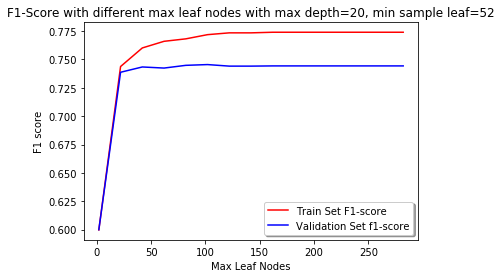

[  2  22  42  62  82 102 122 142 162 182 202 222 242 262 282]
[0.5999455006851186, 0.7386835353086001, 0.7433543265088314, 0.7423878205128205, 0.7447912111829061, 0.7454606624314467, 0.7440973527472794, 0.7440973527472794, 0.7442885402002122, 0.7442885402002122, 0.7442885402002122, 0.7442885402002122, 0.7442885402002122, 0.7442885402002122, 0.7442885402002122]


In [82]:
#hyperparameter: max leaf nodes
max_leaf_nodes_collect=np.arange(2,300,20)
F1_valid_collection3=list()
F1_train_collection3=list()
for max_leaf_nodes in max_leaf_nodes_collect:
    model3=tree.DecisionTreeClassifier(criterion='gini',max_depth=20,min_samples_leaf=52,max_leaf_nodes=max_leaf_nodes)
    fit3=model3.fit(X_train,Y_train)
    prediction_train3 = fit3.predict(X_train)
    prediction_valid3 = fit3.predict(X_valid)
    F1_valid3 = f1_score(Y_valid, prediction_valid3, average='macro')   
    F1_train3 = f1_score(Y_train, prediction_train3, average='macro')
    F1_train_collection3.append(F1_train3)
    F1_valid_collection3.append(F1_valid3)
    
#plot 
plt.plot(max_leaf_nodes_collect, F1_train_collection3, color='r', label="Train Set F1-score")
plt.plot(max_leaf_nodes_collect, F1_valid_collection3, color='b', label="Validation Set f1-score")
plt.legend(loc='best', shadow=True)
plt.xlabel('Max Leaf Nodes')
plt.ylabel('F1 score')
plt.title('F1-Score with different max leaf nodes with max depth=20, min sample leaf=52')
plt.show() 

print(max_leaf_nodes_collect)
print(F1_valid_collection3)

In [ ]:
model3=tree.DecisionTreeClassifier(criterion='gini',max_depth=20,min_samples_leaf=52,max_leaf_nodes=102)
fit3=model3.fit(X_train,Y_train)
prediction_train = fit3.predict(X_train)
prediction_valid = fit3.predict(X_valid)
prediction_test = fit3.predict(X_test)
F1_valid = f1_score(Y_valid, prediction_valid, average='macro')   
F1_train = f1_score(Y_train,prediction_train, average='macro')
F1_test = f1_score(Y_test,prediction_test, average='macro')
print("F1 score for train set:",F1_train)
print("F1 score for valid set:",F1_valid)
print("F1 score for test set:",F1_test)

In [27]:
#Q5
#Generate FBoW
for i in range(len(IMDB_valid)):
    if(i==0):
        IMDB_valid_X=np.array(FBW(IMDB_valid["comment"][0],vocab2)).T
    else:
        IMDB_valid_X=np.row_stack((IMDB_valid_X,FBW(IMDB_valid["comment"][i],vocab2).T))

for i in range(len(IMDB_test)):
    if(i==0):
        IMDB_test_X=np.array(FBW(IMDB_test["comment"][0],vocab2)).T
    else:
        IMDB_test_X=np.row_stack((IMDB_test_X,FBW(IMDB_test["comment"][i],vocab2).T))

for i in range(len(IMDB_train)):
    if(i==0):
        IMDB_train_X=np.array(FBW(IMDB_train["comment"][0],vocab2)).T
    else:
        IMDB_train_X=np.row_stack((IMDB_train_X,FBW(IMDB_train["comment"][i],vocab2).T))

In [28]:
X_train=IMDB_train_X
X_valid=IMDB_valid_X
X_test=IMDB_test_X
Y_train=np.array(IMDB_train['rating'])
Y_valid=np.array(IMDB_valid['rating'])
Y_test=np.array(IMDB_test['rating'])

In [29]:
from sklearn.naive_bayes import GaussianNB
#Gaussian Naive Bayes
model= GaussianNB()
fit=model.fit(X_train,Y_train)
prediction_train = fit.predict(X_train)
prediction_valid = fit.predict(X_valid)
F1_valid = f1_score(Y_valid, prediction_valid, average='macro')   
F1_train = f1_score(Y_train,prediction_train, average='macro')
print("F1 score over train set:", F1_train)
print("F1 score over validation set:", F1_valid)

F1 score over train set: 0.8627017402201094
F1 score over validation set: 0.7593849791768671


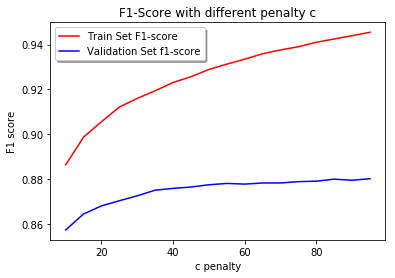

[10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95]
[0.8573720449208044, 0.8644722859377515, 0.8680793874042819, 0.8703825586770956, 0.8725822583536531, 0.8750823104059766, 0.875885253927019, 0.8764878945785476, 0.8774884728904143, 0.8780899046250019, 0.8777896561164937, 0.878289473256542, 0.8782885481694973, 0.8788899708784885, 0.8790912643438489, 0.8799889397806901, 0.8794908786646062, 0.8801947812846728]


In [30]:
#hyperparameter penalty para
c_penalty= np.arange(10, 100, 5)
F1_valid_collection2=list()
F1_train_collection2=list()
for i in c_penalty:
    model2=LinearSVC(C=i)
    fit2= model2.fit(X_train, Y_train)
    prediction_train2 = fit2.predict(X_train)
    prediction_valid2 = fit2.predict(X_valid)
    F1_valid2 = f1_score(Y_valid, prediction_valid2, average='macro')   
    F1_train2 = f1_score(Y_train, prediction_train2, average='macro')
    F1_train_collection2.append(F1_train2)
    F1_valid_collection2.append(F1_valid2)

#plot
plt.plot(c_penalty, F1_train_collection2, color='r', label="Train Set F1-score")
plt.plot(c_penalty, F1_valid_collection2, color='b', label="Validation Set f1-score")
plt.legend(loc='best', shadow=True)
plt.xlabel('c penalty')
plt.ylabel('F1 score')
plt.title('F1-Score with different penalty c')
plt.show() 

print(c_penalty)
print( F1_valid_collection2)

In [31]:
model=LinearSVC(C=90)
fit=model.fit(X_train,Y_train)
prediction_train = fit.predict(X_train)
prediction_valid = fit.predict(X_valid)
prediction_test = fit.predict(X_test)
F1_valid = f1_score(Y_valid, prediction_valid, average='macro')   
F1_train = f1_score(Y_train,prediction_train, average='macro')
F1_test = f1_score(Y_test,prediction_test, average='macro')
print("F1 score for train set:",F1_train)
print("F1 score for valid set:",F1_valid)
print("F1 score for test set:",F1_test)

F1 score for train set: 0.943665258298124
F1 score for valid set: 0.8796882082412898
F1 score for test set: 0.8753178835958833


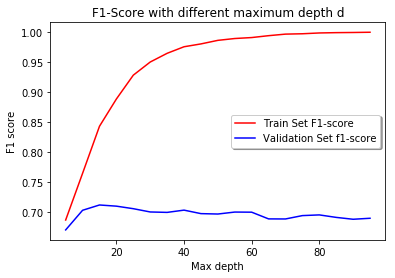

[ 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95]
[0.6700904169974834, 0.7028554127454485, 0.7116913868665238, 0.7097367950187305, 0.7055059300014622, 0.7000389589039862, 0.6993393747915331, 0.7030984293906914, 0.6972738172124507, 0.6965998907759607, 0.699884871196357, 0.6996762113527013, 0.6884815300699179, 0.6883736239435305, 0.6939794231764144, 0.695138527732732, 0.6909896048903086, 0.687869408080686, 0.6895319950882042]


In [32]:
#Decision tree
#hyperparameter max depth
depth = np.arange(5,100,5)
F1_valid_collection3=list()
F1_train_collection3=list()
for i in depth:
    model3=tree.DecisionTreeClassifier(criterion='gini',max_depth=i)
    fit3=model3.fit(X_train,Y_train)
    prediction_train3 = fit3.predict(X_train)
    prediction_valid3 = fit3.predict(X_valid)
    F1_valid3 = f1_score(Y_valid, prediction_valid3, average='macro')   
    F1_train3 = f1_score(Y_train, prediction_train3, average='macro')
    F1_train_collection3.append(F1_train3)
    F1_valid_collection3.append(F1_valid3)
#plot
plt.plot(depth, F1_train_collection3, color='r', label="Train Set F1-score")
plt.plot(depth, F1_valid_collection3, color='b', label="Validation Set f1-score")
plt.legend(loc='best', shadow=True)
plt.xlabel('Max depth')
plt.ylabel('F1 score')
plt.title('F1-Score with different maximum depth d')
plt.show() 
print(depth)
print(F1_valid_collection3)

In [33]:
model3=tree.DecisionTreeClassifier(criterion='gini',max_depth=20)
fit3=model3.fit(X_train,Y_train)
prediction_train = fit3.predict(X_train)
prediction_valid = fit3.predict(X_valid)
prediction_test = fit3.predict(X_test)
F1_valid = f1_score(Y_valid, prediction_valid, average='macro')   
F1_train = f1_score(Y_train,prediction_train, average='macro')
F1_test = f1_score(Y_test,prediction_test, average='macro')
print("F1 score for train set:",F1_train)
print("F1 score for valid set:",F1_valid)
print("F1 score for test set:",F1_test)

F1 score for train set: 0.8892273608418719
F1 score for valid set: 0.7104576764139334
F1 score for test set: 0.7120191690829805


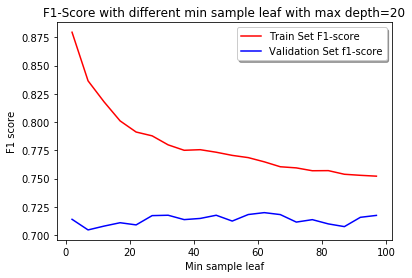

[ 2  7 12 17 22 27 32 37 42 47 52 57 62 67 72 77 82 87 92 97]
[0.7139930784722149, 0.7046124268550029, 0.7079928119334219, 0.7109745432132105, 0.7090536236990845, 0.7172693068720899, 0.7175968627450982, 0.7137311039810865, 0.7147699448467155, 0.717594321269285, 0.7124513522223048, 0.7182274667881523, 0.719907222068238, 0.7181884271435623, 0.7115418352956691, 0.7136966444886604, 0.7099354495273869, 0.7075341951939186, 0.715766157125729, 0.7174574400376978]


In [34]:
#hyperparameter: min sample leaf
min_samples_leaves = np.arange(2, 100, 5)
F1_valid_collection3=list()
F1_train_collection3=list()
for min_samples_leaf in min_samples_leaves:
    model3=tree.DecisionTreeClassifier(criterion='gini',max_depth=20,min_samples_leaf=min_samples_leaf)
    fit3=model3.fit(X_train,Y_train)
    prediction_train3 = fit3.predict(X_train)
    prediction_valid3 = fit3.predict(X_valid)
    F1_valid3 = f1_score(Y_valid, prediction_valid3, average='macro')   
    F1_train3 = f1_score(Y_train, prediction_train3, average='macro')
    F1_train_collection3.append(F1_train3)
    F1_valid_collection3.append(F1_valid3)
    
#plot 
plt.plot(min_samples_leaves, F1_train_collection3, color='r', label="Train Set F1-score")
plt.plot(min_samples_leaves, F1_valid_collection3, color='b', label="Validation Set f1-score")
plt.legend(loc='best', shadow=True)
plt.xlabel('Min sample leaf')
plt.ylabel('F1 score')
plt.title('F1-Score with different min sample leaf with max depth=20')
plt.show() 

print(min_samples_leaves)
print(F1_valid_collection3)

In [35]:
model3=tree.DecisionTreeClassifier(criterion='gini',max_depth=20,min_samples_leaf=47)
fit3=model3.fit(X_train,Y_train)
prediction_train = fit3.predict(X_train)
prediction_valid = fit3.predict(X_valid)
prediction_test = fit3.predict(X_test)
F1_valid = f1_score(Y_valid, prediction_valid, average='macro')   
F1_train = f1_score(Y_train,prediction_train, average='macro')
F1_test = f1_score(Y_test,prediction_test, average='macro')
print("F1 score for train set:",F1_train)
print("F1 score for valid set:",F1_valid)
print("F1 score for test set:",F1_test)

F1 score for train set: 0.7734452741982862
F1 score for valid set: 0.7168190136663104
F1 score for test set: 0.7251833449883782


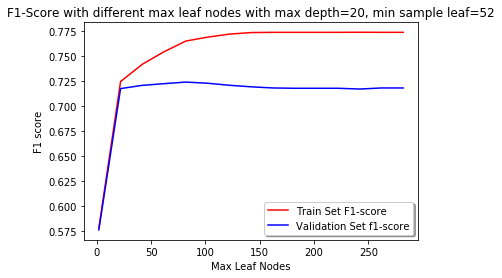

[  2  22  42  62  82 102 122 142 162 182 202 222 242 262 282]
[0.5763827509464391, 0.717268828888385, 0.7204987673995642, 0.7221733175254152, 0.7237723772377238, 0.7226150508593256, 0.720596314713426, 0.7190439275119715, 0.7179001956118884, 0.717594321269285, 0.717594321269285, 0.717594321269285, 0.7168190136663104, 0.7179001956118884, 0.7179001956118884]


In [36]:
#hyperparameter: max leaf nodes
max_leaf_nodes_collect=np.arange(2,300,20)
F1_valid_collection3=list()
F1_train_collection3=list()
for max_leaf_nodes in max_leaf_nodes_collect:
    model3=tree.DecisionTreeClassifier(criterion='gini',max_depth=20,min_samples_leaf=47,max_leaf_nodes=max_leaf_nodes)
    fit3=model3.fit(X_train,Y_train)
    prediction_train3 = fit3.predict(X_train)
    prediction_valid3 = fit3.predict(X_valid)
    F1_valid3 = f1_score(Y_valid, prediction_valid3, average='macro')   
    F1_train3 = f1_score(Y_train, prediction_train3, average='macro')
    F1_train_collection3.append(F1_train3)
    F1_valid_collection3.append(F1_valid3)
    
#plot 
plt.plot(max_leaf_nodes_collect, F1_train_collection3, color='r', label="Train Set F1-score")
plt.plot(max_leaf_nodes_collect, F1_valid_collection3, color='b', label="Validation Set f1-score")
plt.legend(loc='best', shadow=True)
plt.xlabel('Max Leaf Nodes')
plt.ylabel('F1 score')
plt.title('F1-Score with different max leaf nodes with max depth=20, min sample leaf=52')
plt.show() 

print(max_leaf_nodes_collect)
print(F1_valid_collection3)


In [37]:
model3=tree.DecisionTreeClassifier(criterion='gini',max_depth=20,min_samples_leaf=47,max_leaf_nodes=102)
fit3=model3.fit(X_train,Y_train)
prediction_train = fit3.predict(X_train)
prediction_valid = fit3.predict(X_valid)
prediction_test = fit3.predict(X_test)
F1_valid = f1_score(Y_valid, prediction_valid, average='macro')   
F1_train = f1_score(Y_train,prediction_train, average='macro')
F1_test = f1_score(Y_test,prediction_test, average='macro')
print("F1 score for train set:",F1_train)
print("F1 score for valid set:",F1_valid)
print("F1 score for test set:",F1_test)

F1 score for train set: 0.7680358113057625
F1 score for valid set: 0.7232246479103936
F1 score for test set: 0.7289109921532619
